In [1]:
import argparse
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

from torchvision import datasets, transforms, utils

from scheduler import CycleScheduler

# Data

In [2]:
class vid_faces(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None):

        self.filenames = glob.glob('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/*vid*.npy')
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
          
        img = torch.Tensor(np.load(self.filenames[idx]))
        aud = torch.Tensor(np.load(self.filenames[idx].split('_vid_')[0] + '_aud_' + self.filenames[idx].split('_vid_')[1]))
        
        img = img.permute(2,0,1)
        
        sample = {'image': img, 'audio': aud}

        return sample

In [3]:
# grab the names of the pre-processed video files
video_filenames_proc = glob.glob('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/*vid*.npy')

# build datasets
dataset = vid_faces()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=16)

# Model

In [12]:
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', embed.clone())

    def forward(self, x):
        flatten = x.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*x.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                1 - self.decay, embed_onehot.sum(0)
            )
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - x).pow(2).mean()
        quantize = x + (quantize - x).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, x):
        out = self.conv(x)
        out += x

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()
        
        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        
        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        
        self.dec_t = Decoder(embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        
        self.upsample_t = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        
        
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, x):
   
        quant_t, quant_b, diff, _, _ = self.encode(x)
   
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, x):
        
        enc_b = self.enc_b(x)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        
        upsample_t = self.upsample_t(quant_t)
        
        quant = torch.cat([upsample_t, quant_b], 1)
        
        
        dec = self.dec(quant)

        return dec

    # not used
    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

# Train

In [13]:
device = 'cuda'

latent_loss_weight = 0.25

LR = 1e-3

mse_sum = 0
mse_n = 0

model = nn.DataParallel(VQVAE()).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE:  0.05112065002322197 latent loss:  1.8110499382019043 avg MSE:  0.0776204427375513


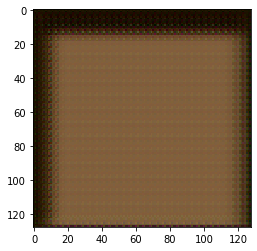

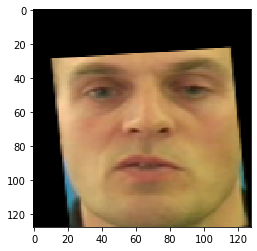

In [ ]:
for i, batch in enumerate(dataloader):
    
    model.zero_grad()

    img = batch['image'].to(device)
  
    out, latent_loss = model(img)
    recon_loss = criterion(out, img)
    latent_loss = latent_loss.mean()
    
    loss = recon_loss + latent_loss_weight * latent_loss
    loss.backward()

    if scheduler is not None:
        scheduler.step()
    
    optimizer.step()

    mse_sum += recon_loss.item() * img.shape[0]
    mse_n += img.shape[0]

    lr = optimizer.param_groups[0]['lr']

    if i % 50 == 0 and i != 0:
        print("MSE: ", recon_loss.item(), "latent loss: ", latent_loss.item(), "avg MSE: ", mse_sum / mse_n)
        test_img = np.moveaxis(out.cpu().detach().numpy(),1,-1)
        inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
        plt.imshow(test_img[0])
        plt.show()
        plt.imshow(inp_img[0])
        plt.show()
        
    
#     loader.set_description(
#         (
#             f'epoch: {epoch + 1}; mse: {recon_loss.item():.5f}; '
#             f'latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; '
#             f'lr: {lr:.5f}'
#         )
#     )

#     if i % 100 == 0:
#         model.eval()

#         sample = img[:sample_size]

#         with torch.no_grad():
#             out, _ = model(sample)

#         utils.save_image(
#             torch.cat([sample, out], 0),
#             f'sample/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png',
#             nrow=sample_size,
#             normalize=True,
#             range=(-1, 1),
#         )

#         model.train()

In [ ]:
inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
plt.imshow(inp_img[60])
plt.show()